In [1]:
import pandas as pd
import matplotlib.pylab as plt
 
import numpy as np
import pyWDFml.classify
%matplotlib inline
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('ggplot') 
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (14, 10)
 
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [2]:
direc='/home/cuoco/CleanWorks/WDF/wdfml/wdfml/output/H1:GDS-CALIB_STRAIN_1167559536/' 
fileIn='WDFTrigger-H1:GDS-CALIB_STRAIN-GPS1167559536-AR3000-Win256-Ov232-SNR5.csv'
 
infile=direc+fileIn
triggers = pd.read_csv(infile, index_col=False)
 

In [3]:
triggers.head(10)

,Duration,FreqMax,GPSMax,GPSstart,SNRMax,WavCoeff,WaveletFam
0,0.000000,0.0,1.167560e+09,1.167560e+09,5.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",initWave
1,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
2,0.017578,203.0,1.167560e+09,1.167560e+09,7.001511,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT
3,0.000000,608.0,1.167560e+09,1.167560e+09,5.297187,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT
4,0.011719,187.0,1.167560e+09,1.167560e+09,6.291858,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT
5,0.000000,1536.0,1.167560e+09,1.167560e+09,5.090548,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT
6,0.000000,1544.0,1.167560e+09,1.167560e+09,5.642491,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT
7,0.005859,1504.0,1.167560e+09,1.167560e+09,5.353410,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT
8,0.000000,1568.0,1.167560e+09,1.167560e+09,6.027961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT
9,0.005859,1568.0,1.167560e+09,1.167560e+09,5.374404,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DCT


In [4]:
triggers['WaveletFam'].unique()

array(['initWave', nan, 'DCT'], dtype=object)

(92, 7)


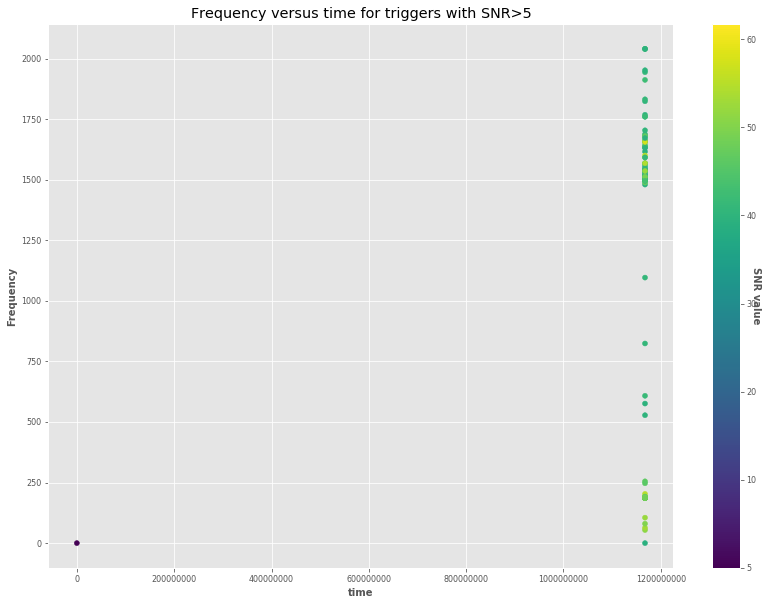

In [5]:
 
print (triggers.shape)
 
from matplotlib.ticker import FormatStrFormatter
color = [str(item/255.) for item in triggers.SNRMax]
sc = plt.scatter(triggers.GPSMax,
                 triggers.FreqMax, s=25, \
                 c=color)
# legend
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(['5','10', '20', '30', '40', '50', '60','>60'])
cbar.set_label('SNR value', rotation=270)

#plt.ylim(0, 2500)
 
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel("time")
plt.ylabel("Frequency")
plt.title("Frequency versus time for triggers with SNR>5")

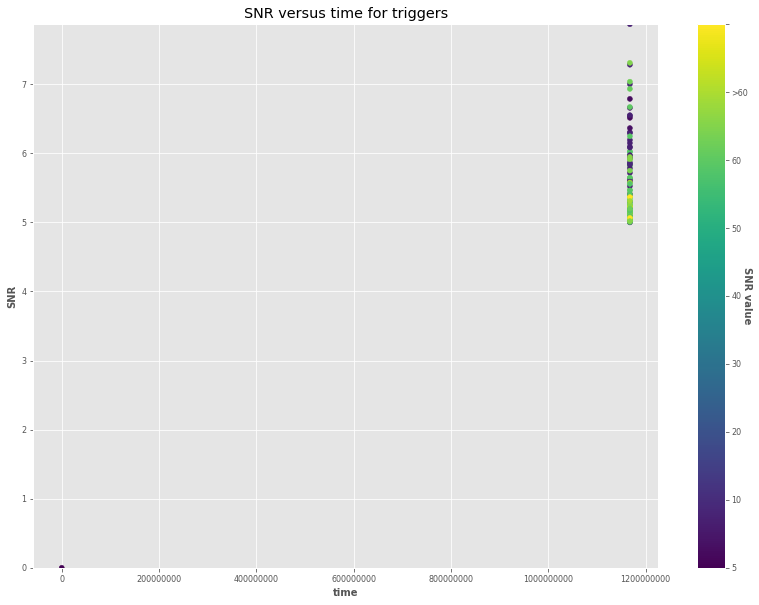

In [6]:
color = [str(item/255.) for item in triggers.FreqMax]
sc = plt.scatter(triggers.GPSMax,
                 triggers.SNRMax, s=25, \
                 c=color)
# legend
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(['5','10', '20', '30', '40', '50', '60','>60'])
cbar.set_label('SNR value', rotation=270)

plt.ylim(0, max(triggers.SNRMax))
 
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.xlabel("time")
plt.ylabel("SNR")
plt.title("SNR versus time for triggers")

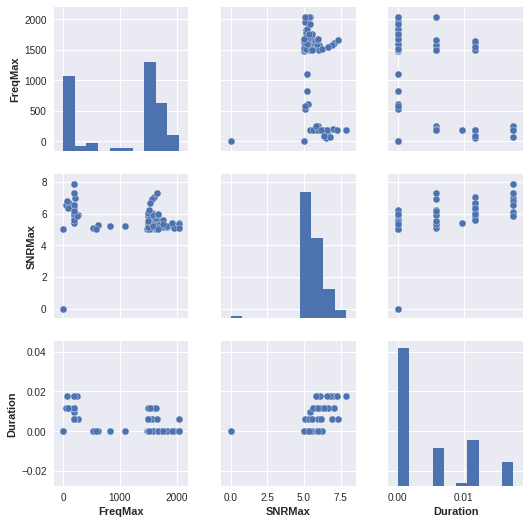

In [7]:
import seaborn as sns
metatriggers=triggers[['FreqMax','SNRMax','Duration']]
sns.pairplot(metatriggers)

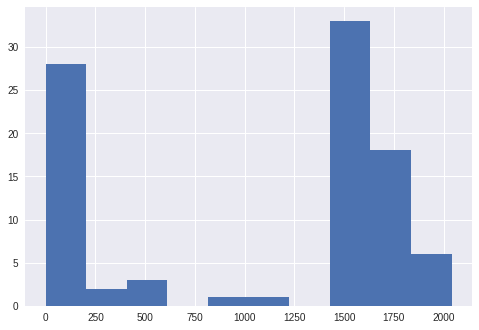

In [8]:
triggers['FreqMax'].hist()

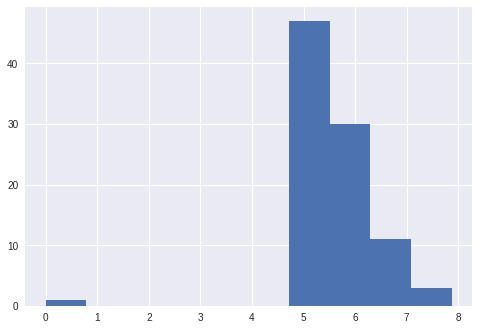

In [9]:
triggers['SNRMax'].hist()

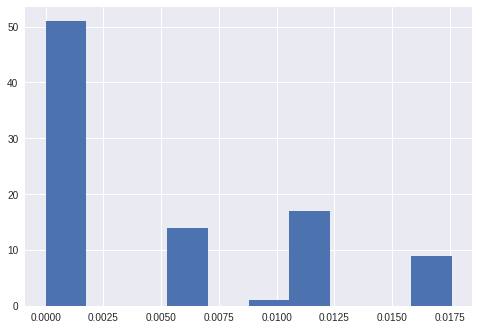

In [10]:
triggers['Duration'].hist()

In [11]:
triggers.dtypes

Duration      float64
FreqMax       float64
GPSMax        float64
GPSstart      float64
SNRMax        float64
WavCoeff       object
WaveletFam     object
dtype: object

In [12]:
triggers['WavCoeff'].head(10)

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: WavCoeff, dtype: object

In [13]:
triggers['WavCoeff']. 

SyntaxError: invalid syntax (<ipython-input-13-a5a446393384>, line 1)

In [ ]:
# expand df.tags into its own dataframe
tags = triggers['WavCoeff'].apply(pd.Series)



In [ ]:
# rename each variable is tags
tags = tags.rename(columns = lambda x : 'wavcoeff_' + str(x))

# view the tags dataframe
tags

In [ ]:
# join the tags dataframe back to the original dataframe
pd.concat([df[:], tags[:]], axis=1)

In [ ]:
dff=np.asarray(df)

In [ ]:
dff.shape

In [ ]:
X = np.asarray(df)
print (X.shape)
pca_comp=10
spectral_emb=2
n_neighbors=15
ml = pyWDFml.classify.WDFMLClassify(X)
#ml.PreprocessingSparsePCA(pca_comp,spectral_emb,n_neighbors)
ml.PreprocessingPCA(pca_comp,spectral_emb,n_neighbors,whiten=True)
#ml.PreprocessingEmb(spectral_emb,n_neighbors)
#ml.PreprocessingRBM(pca_comp,spectral_emb,n_neighbors)
ml.Classify(10)
#plt.figure(0)
#plt.plot(ml.pca.explained_variance_)
ml.PlotClustering()

# write results on file
outfile = direc+'H1-Clustered-Type-2048Hz-SNR4.txt'

dfjo = pd.DataFrame(
    dict(GPSMax=triggers['GPSMax'].values, FreqMax=triggers['FreqMax'].values, SNRMax=triggers['SNRMax'].values,
         GPSstart=triggers['GPSstart'].values,Duration=triggers['Duration'], WaveletFam=triggers['WaveletFam'],LABEL=ml.labels.astype(int)),
    columns=['GPSMax', 'FreqMax','SNRMax', 'GPSstart','Duration','WaveletFam','LABEL'])

dfjo.to_csv(outfile, index_label='ID',float_format='%.5f')



# legend
groups = dfjo.groupby('LABEL')
# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.GPSMax, group.FreqMax, marker='o', linestyle='', ms=7, label=name)
ax.legend()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()